In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
#from specutils.fitting import find_lines_threshold, find_lines_derivative
#from scipy.optimize import curve_fit
#from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks
from specutils.manipulation import LinearInterpolatedResampler

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [2]:
spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [193]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [194]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [ ]:
INST_head = [fits.getheader(file, ext=0) for file in spectrum_files]
SCI_head = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [50]:
#date = [header['DATE-OBS'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header_0]
#instrument_filter = [header['OPT_ELEM'] for header in spectrum_header_0]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
#lab_emission_lines = lines['lab_lambda']
#transition_grouped_lines = lines.groupby("[nu', J']")

In [ ]:
spectrum_x1d[0]

WAVELENGTH,FLUX,ERROR,SNR,EFF_EXPTIME
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,s
float32[59914],float32[59914],float32[59914],float32[59914],float32[59914]
1135.6062 .. 1795.7308,-9.243304e-17 .. 3.5043925e-14,8.496804e-16 .. 9.7835134e-15,-0.10878565 .. 3.5819366,1199.168 .. 1382.176


In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)

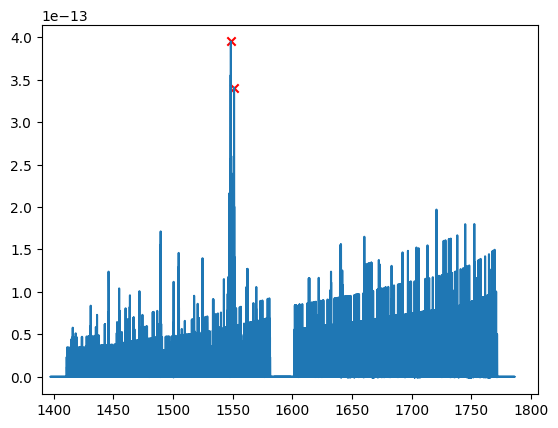

In [ ]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [ ]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

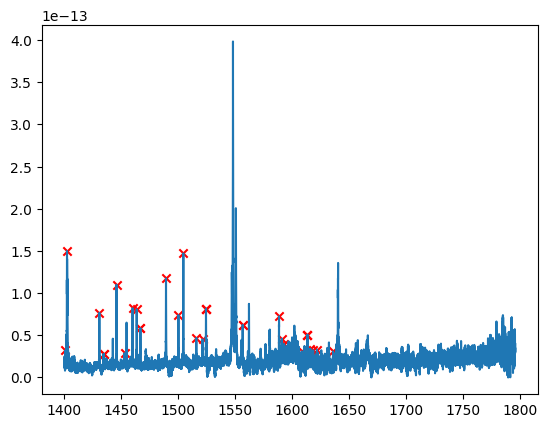

In [ ]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [ ]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

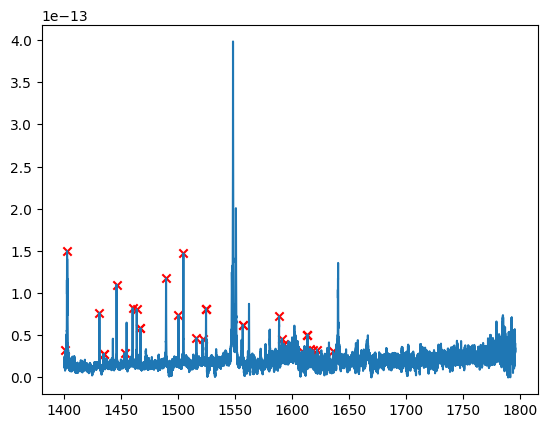

In [ ]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [ ]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [ ]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

,Line ID,"[nu', J']",lab_lambda,spec_flux,spec_fluxerr,spec_wavelength
"[nu', J']",,,,,,
"[3,13]",(3–9)P(14),"[3,13]",1608.33,[1.7703417196286188e-14 cm2 erg / (Angstrom s)...,[3.3116178205840627e-15 cm2 erg / (Angstrom s)...,"[1606.56494140625 Angstrom, 1606.5772705078125..."
"[3,13]",(3–10)R(12),"[3,13]",1615.43,"[2.078932254752537e-14 cm2 erg / (Angstrom s),...",[2.9581416543324234e-15 cm2 erg / (Angstrom s)...,"[1614.133056640625 Angstrom, 1614.145385742187..."
"[4,13]",(4–11)R(12),"[4,13]",1613.99,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[3,16]",(3–7)R(15),"[3,16]",1513.99,[1.9793437112318284e-14 cm2 erg / (Angstrom s)...,[1.8945835805956376e-15 cm2 erg / (Angstrom s)...,"[1513.959716796875 Angstrom, 1513.972045898437..."
"[3,16]",(3–9)R(15),"[3,16]",1593.26,"[3.643838838518834e-14 cm2 erg / (Angstrom s),...","[3.618663240557247e-15 cm2 erg / (Angstrom s),...","[1591.036865234375 Angstrom, 1591.049194335937..."
"[3,16]",(3–10)R(15),"[3,16]",1621.12,[1.8693229405261462e-14 cm2 erg / (Angstrom s)...,[2.8322530766126475e-15 cm2 erg / (Angstrom s)...,"[1619.9132080078125 Angstrom, 1619.92553710937..."
"[4,4]",(4–9)P(5),"[4,4]",1526.55,[2.3042643639524518e-14 cm2 erg / (Angstrom s)...,"[2.075113618468078e-15 cm2 erg / (Angstrom s),...","[1522.4462890625 Angstrom, 1522.4586181640625 ..."
"[4,4]",(4–11)P(5),"[4,4]",1613.72,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[1,7]",(1–6)P(8),"[1,7]",1467.08,[2.2690731943126458e-14 cm2 erg / (Angstrom s)...,[1.8396350709995934e-15 cm2 erg / (Angstrom s)...,"[1464.8773193359375 Angstrom, 1464.88952636718..."


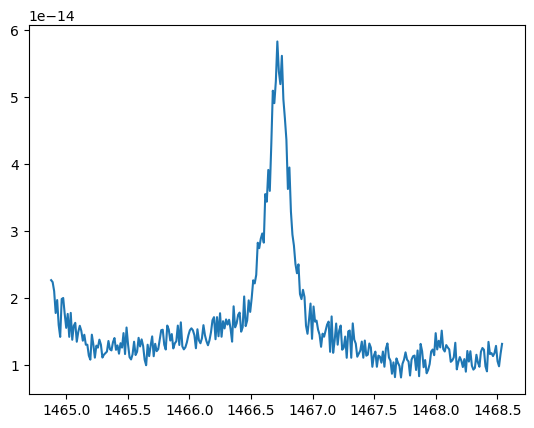

In [ ]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [30]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
#plt.rcParams['figure.dpi'] = 300

In [50]:
#Keep units for future math
class spectrum():
    def __init__(self, files):
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)
            
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS']
            instrument = INST_head['INSTRUME']
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date,
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength*self.wavelength_units, 
                       'flux': self.x1d_flux*self.flux_units, 
                       'fluxerr':self.x1d_fluxerr*self.flux_units}
            rows.append(pd.Series(df_data))
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)

    def coaddwave(self, df, columns = ['obsdate']):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - columns: the columns of unique combinations to apply coadding to.

        Returns:
        - coadded_spectrum: spectrum dictionary
        """
        res = {}
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]

            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]

            resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
            wavelengths = group['wavelength'].values
            fluxes = group['flux'].values
            fluxerrs = group['fluxerr'].values
            base_wave = wavelengths[0]
            spectra = []

            for wave, flux, err in zip(wavelengths, fluxes, fluxerrs):
                wavesort_idx = np.argsort(wave)
                spec = Spectrum1D(spectral_axis=wave[wavesort_idx], flux=flux[wavesort_idx], uncertainty=StdDevUncertainty(err[wavesort_idx]))
                spec_resampled = resampler(spec, np.sort(base_wave))
                spectra.append(spec_resampled)

            coadded = np.sum(spectra)
            coadd_wave = coadded.wavelength
            coadd_flux = coadded.flux
            coadd_err = coadded.uncertainty.quantity.to(self.flux_units)
            spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}
            res[tuple(unique_values)] = spec_dict

        stacked_df = pd.DataFrame([
            {**dict(zip(columns, k)), **(v if v is not None else {})}
            for k, v in res.items()
        ])

        return stacked_df
    
    def H2lines_fromspectrum(self, df, linelist):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = None
        df["[nu', J']"] = None
        df["rest_wavelength"] = None
        for i in range(len(df)):
            row = df.iloc[i]
            peaks , _ = find_peaks(np.array(row['flux'].value), height=np.array(row['fluxerr'].value)*2, distance=50)
            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = []
            nu_J = []
            lab_lines = []
            if len(peaks)>=0.5:
                for il, l in enumerate(linelist['lab_lambda']):
                    diff = abs(row['wavelength'][peaks]/u.AA-l)
                    if min(diff) <= 2:
                        emission_table_idx.append(np.argmin(diff))
                        nu_J.append(linelist['[nu\', J\']'].iloc[il])
                        lab_lines.append(l)
            else:
                pass
            df.at[i, 'H2line_idx'] = np.array(peaks)[emission_table_idx]
            df.at[i, "[nu', J']"] = nu_J
            df.at[i, 'rest_wavelength'] = lab_lines
        return df

    #next step is to coadd full spectra and then get line properties

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [51]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
cspec_files = ['HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e305_cspec.fits',
'HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e3_cspec.fits',
'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e305_cspec.fits',
'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e3_cspec.fits',
'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e305_cspec.fits',
'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e3_cspec.fits']
spectrum_files = np.hstack([x1dsum_files, cspec_files])
all_spectra = spectrum(spectrum_files)

In [52]:
linelist = pd.read_csv('HST/emission_lines.csv', skiprows=2)

In [53]:
stacked_df = all_spectra.coaddwave(all_spectra.spec_df, columns = ['obsdate', 'filter'])

In [54]:
all_spectra.H2lines_fromspectrum(stacked_df, linelist)

,obsdate,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']",rest_wavelength
0,2011-07-20,G130M,"[1124.7185766387568 Angstrom, 1124.72853832954...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[31744, 28522, 28891, 28159, 29353]","[[1,4], [0,1], [0,2], [0,3], [0,3]]","[1431.01, 1398.95, 1402.65, 1395.2, 1407.29]"
1,2011-07-20,G160M,"[1386.0412954067515 Angstrom, 1386.05353027634...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[10072, 17936, 11521, 6621, 9356, 11336, 13958...","[[4,13], [3,16], [4,4], [1,7], [1,7], [1,7], [...","[1509.45, 1593.26, 1526.55, 1467.08, 1500.45, ..."
2,2012-02-28,G130M,"[1124.9096635174221 Angstrom, 1124.91962690073...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30139, 30456, 31739, 32095, 28467, 28891, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [...","[1415.33, 1418.23, 1431.01, 1435.05, 1398.95, ..."
3,2012-02-28,G160M,"[1386.2769487823698 Angstrom, 1386.28918573199...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19178, 19697, 2391, 10081, 19629, 2578, 10459...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
4,2021-08-10,G230L,"[1629.7767989689344 Angstrom, 1630.16885217535...",[-8.040355697789332e-16 erg / (Angstrom s cm2)...,"[3.668935098550417e-14 erg / (Angstrom s cm2),...",[],[],[]
5,2021-08-10,G160M,"[1385.9946471407397 Angstrom, 1386.00688689571...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19597, 2424, 10078, 19597, 2620, 10481, 17913...","[[3,13], [4,13], [4,13], [4,13], [3,16], [3,16...","[1615.43, 1415.33, 1509.45, 1613.99, 1418.23, ..."
6,2021-08-11,G160M,"[1385.9941396590698 Angstrom, 1386.00637941009...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[],[]
7,2021-08-12,G230L,"[1302.44952981175 Angstrom, 1302.864435088827 ...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[],[]
8,2021-08-12,G160M,"[1385.9934968299058 Angstrom, 1386.00573657483...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19021, 19603, 2360, 10072, 19603, 2626, 10489...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
9,2021-08-13,G230L,"[1630.0907947696835 Angstrom, 1630.48284648384...","[1.834981277742598e-14 erg / (Angstrom s cm2),...","[4.008633769678648e-14 erg / (Angstrom s cm2),...",[],[],[]


# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

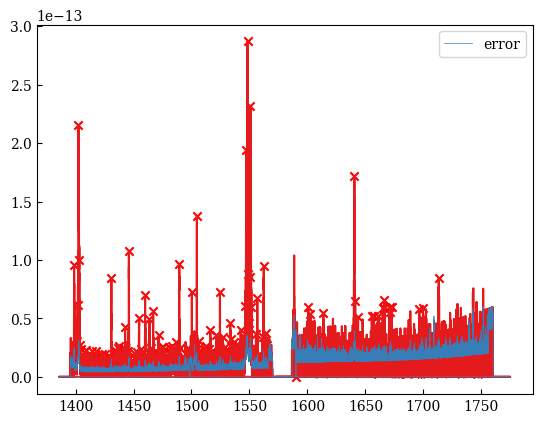

In [44]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

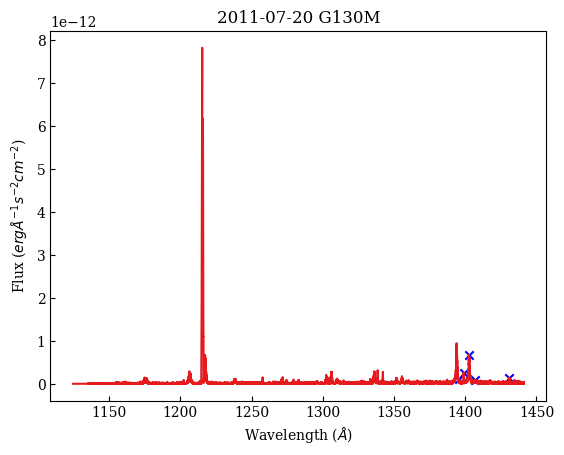

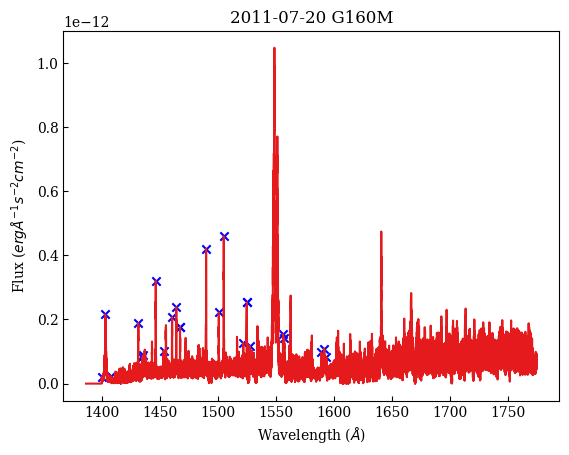

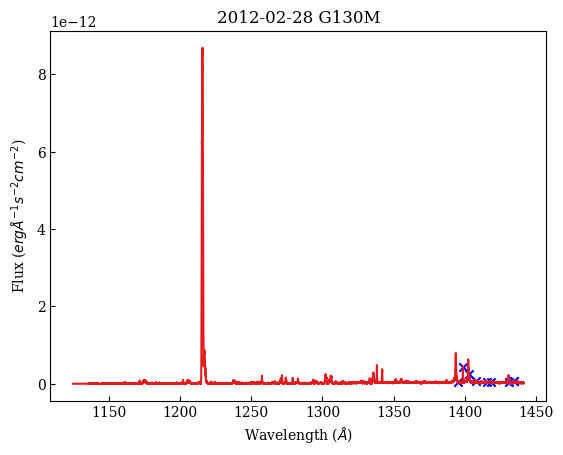

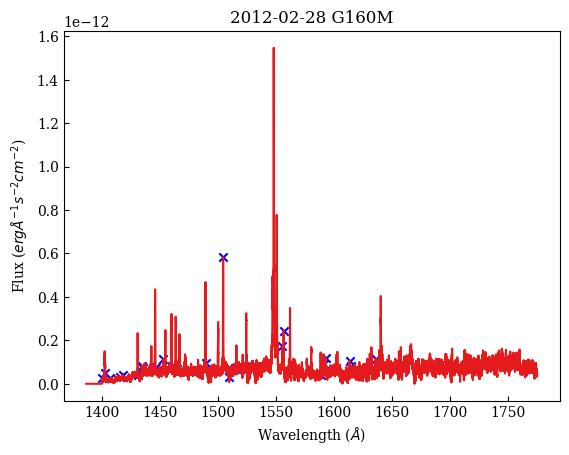

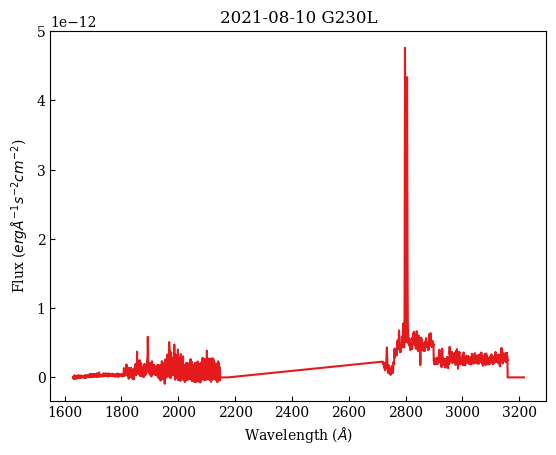

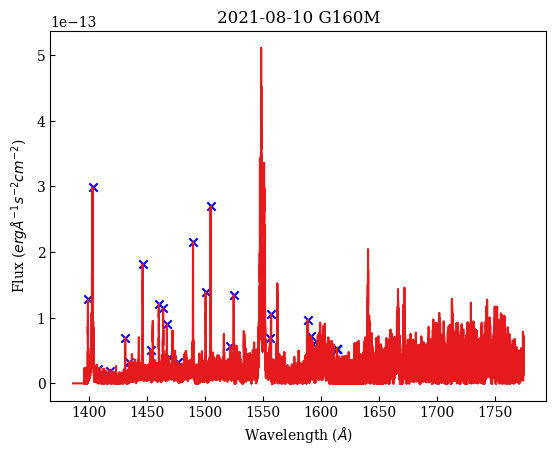

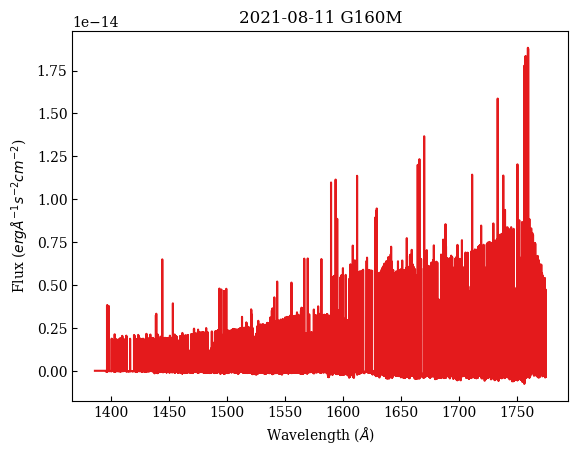

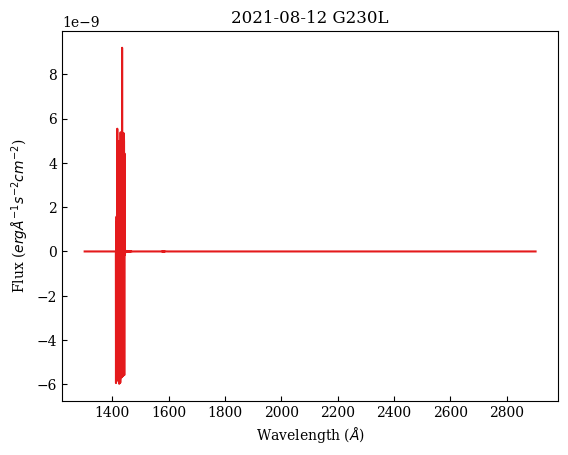

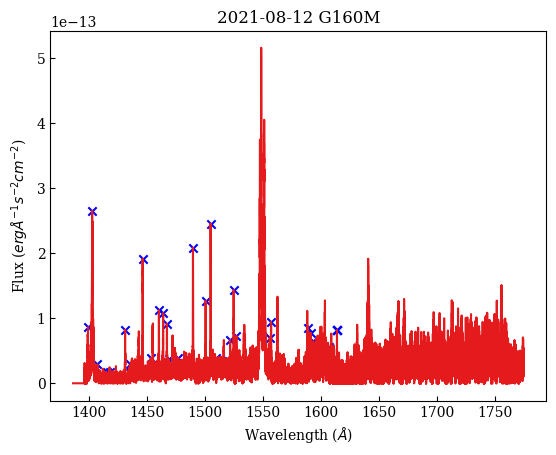

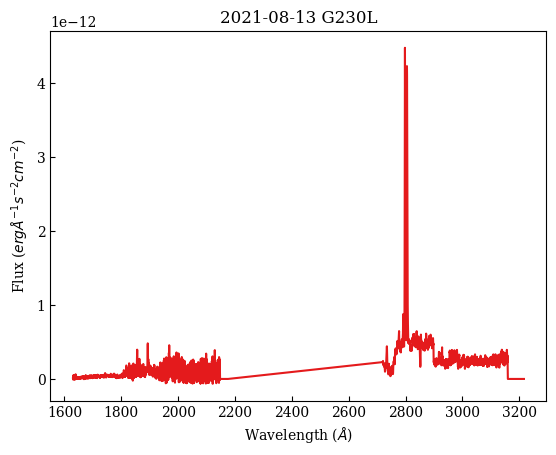

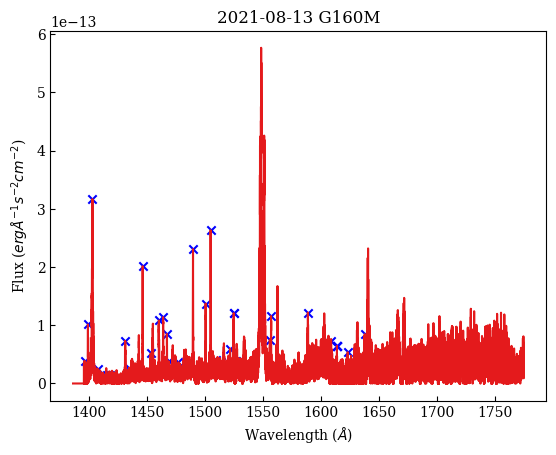

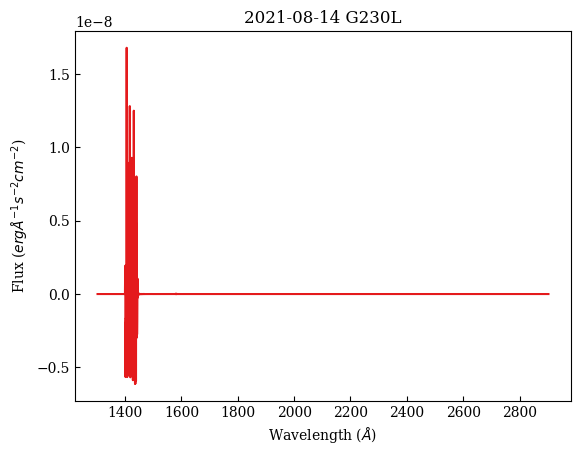

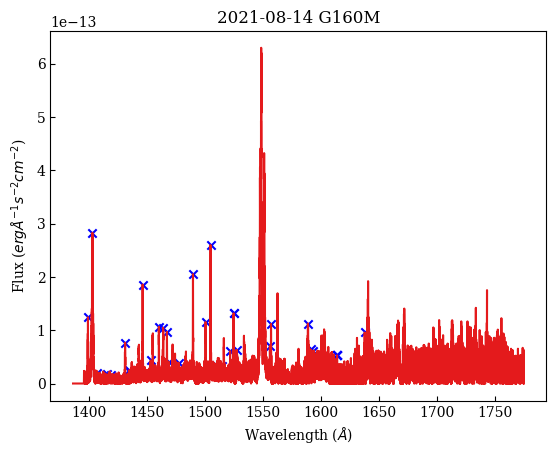

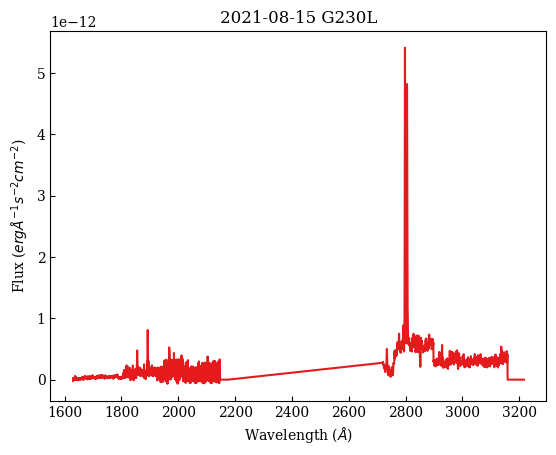

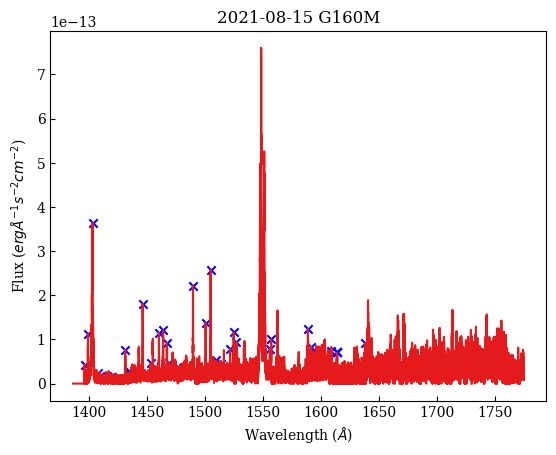

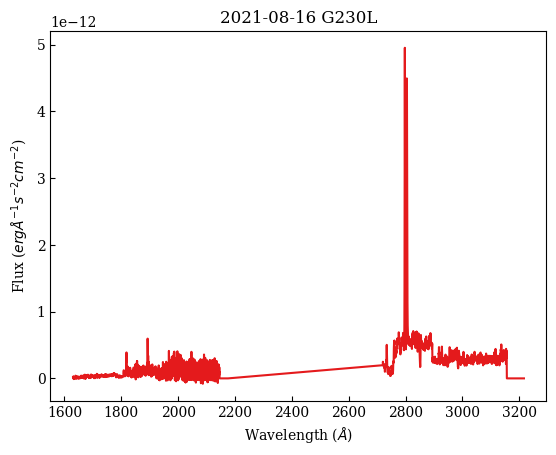

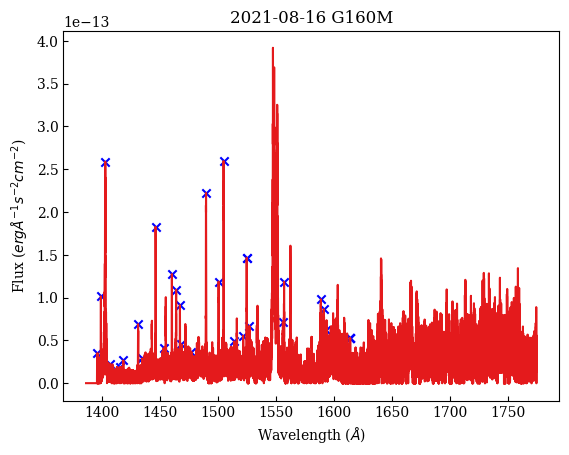

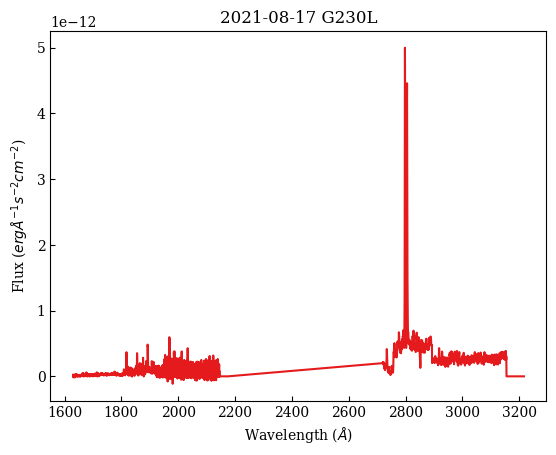

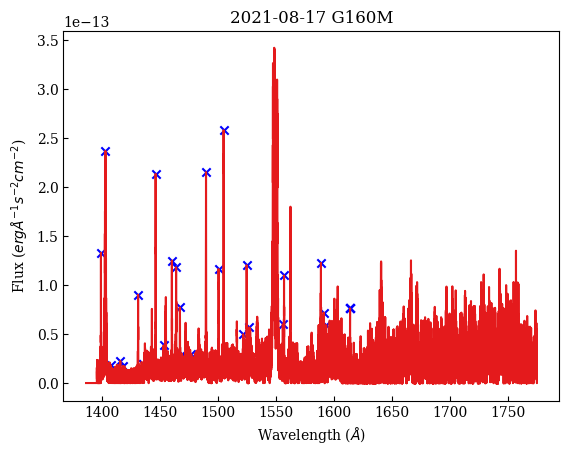

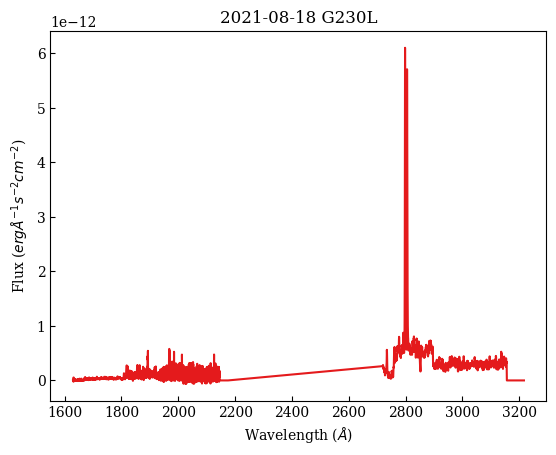

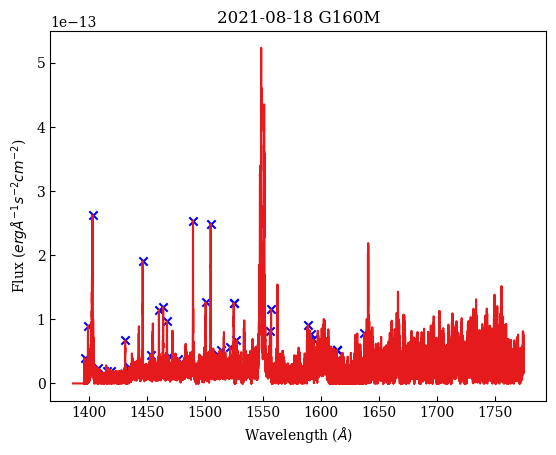

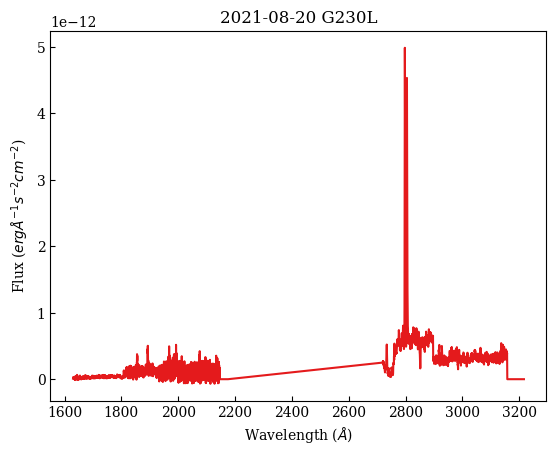

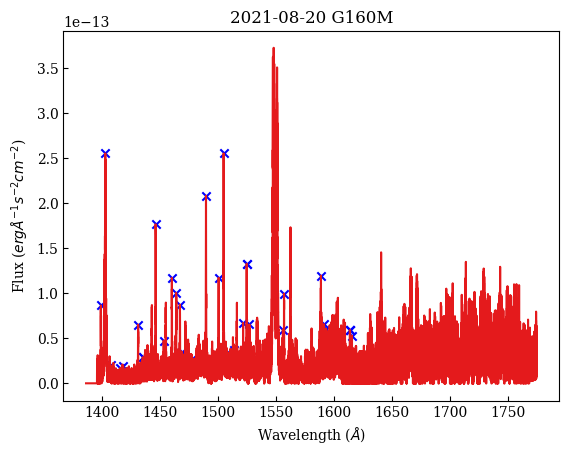

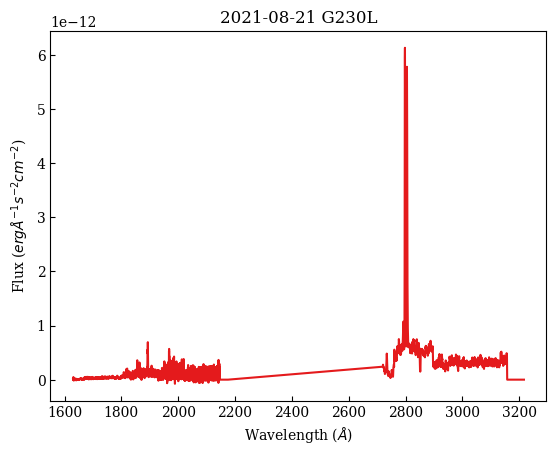

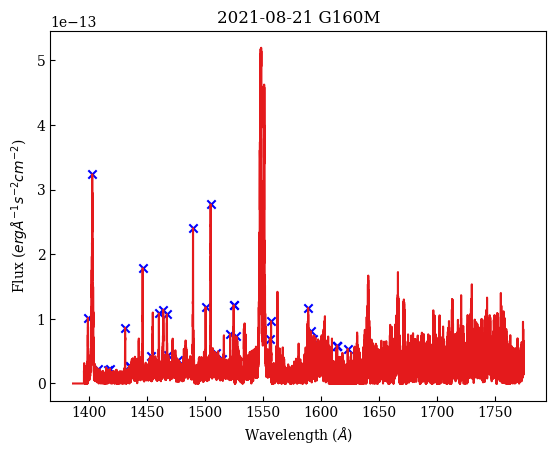

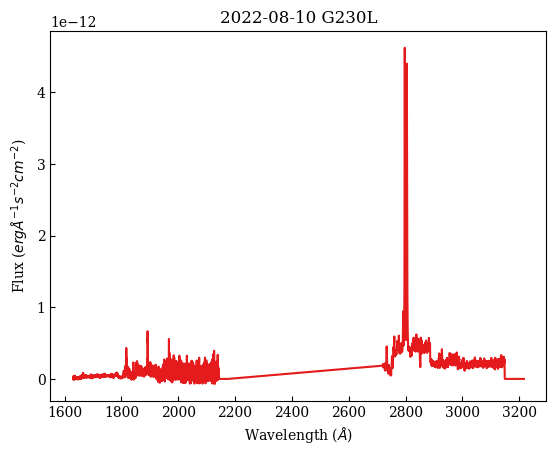

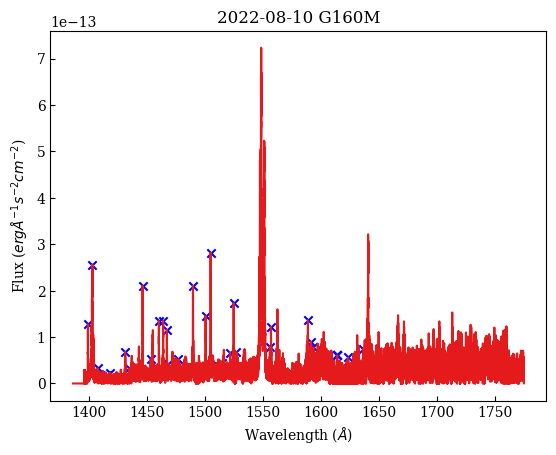

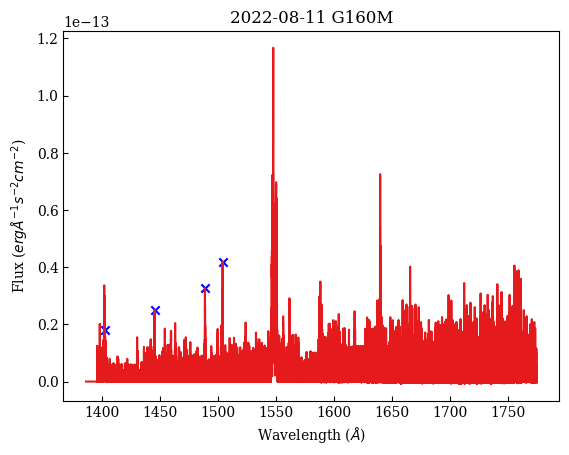

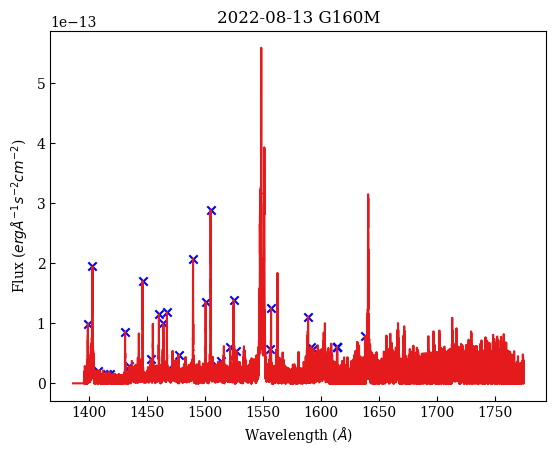

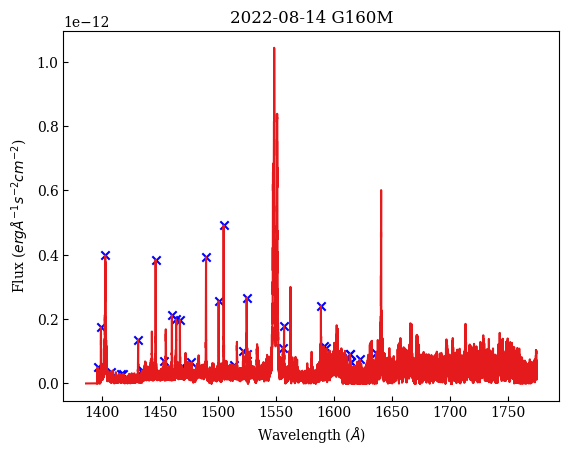

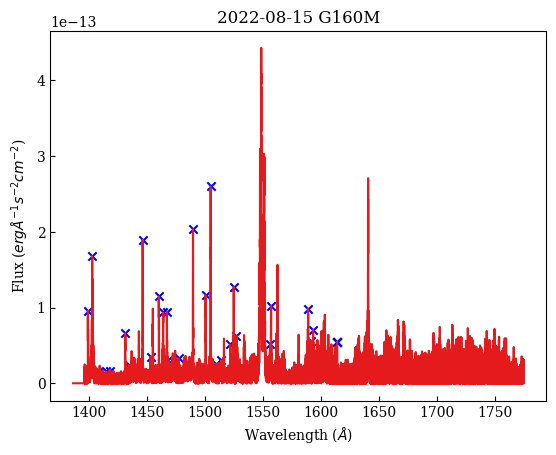

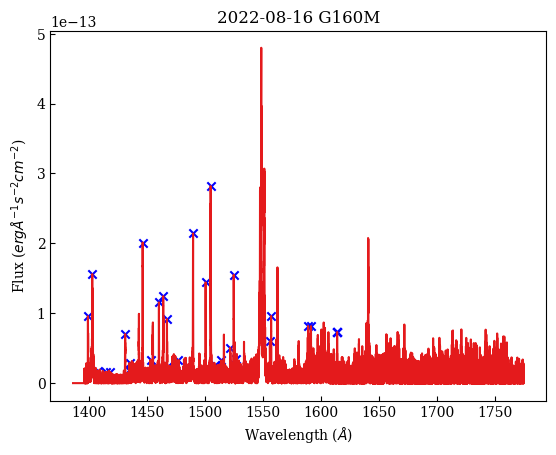

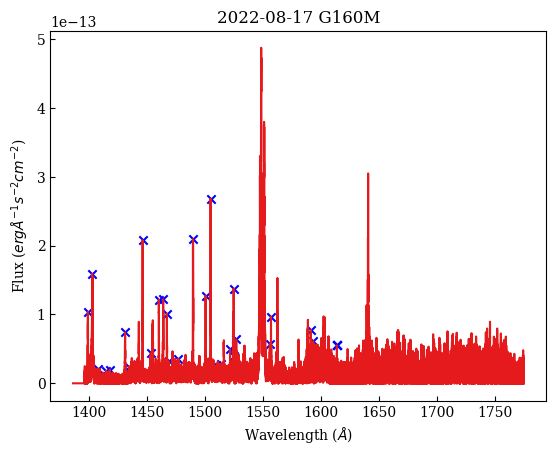

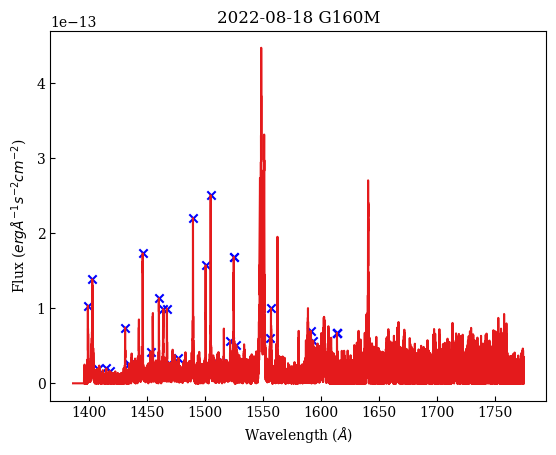

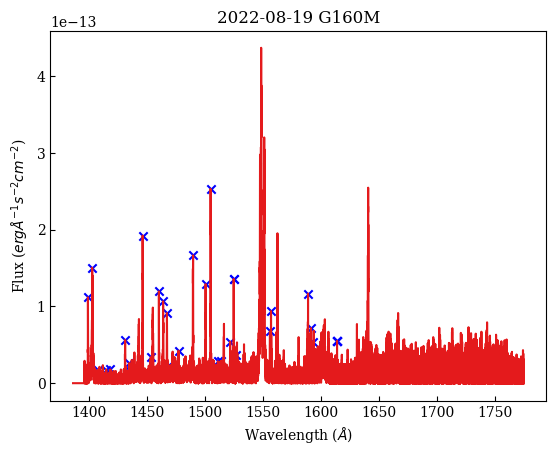

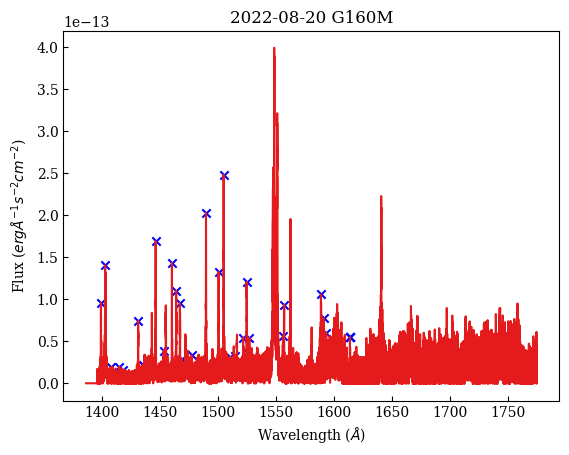

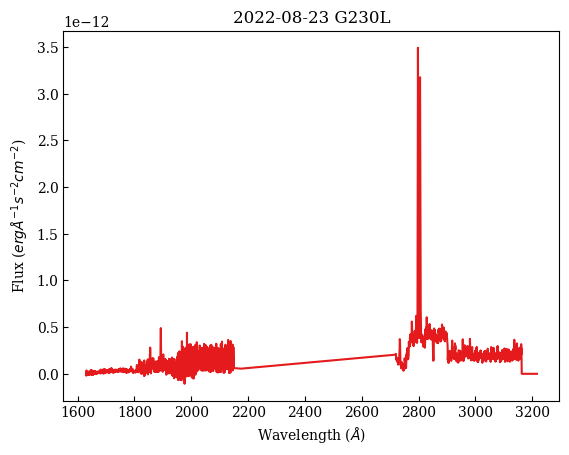

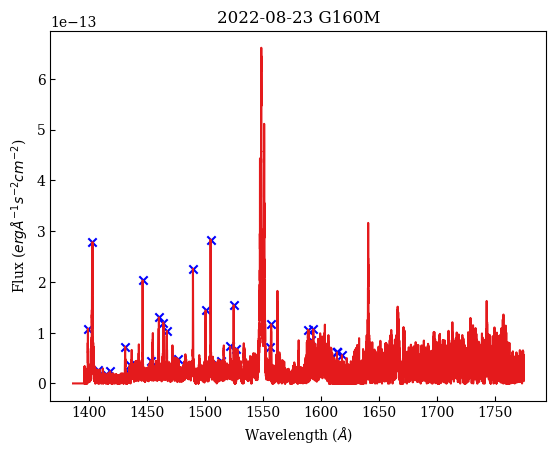

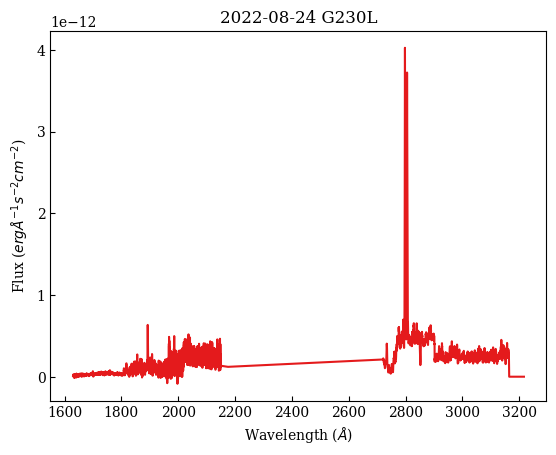

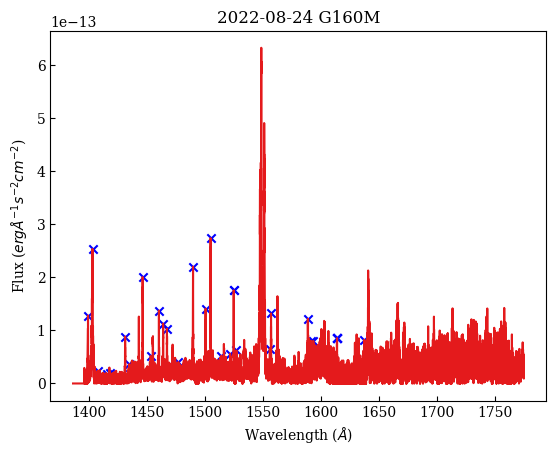

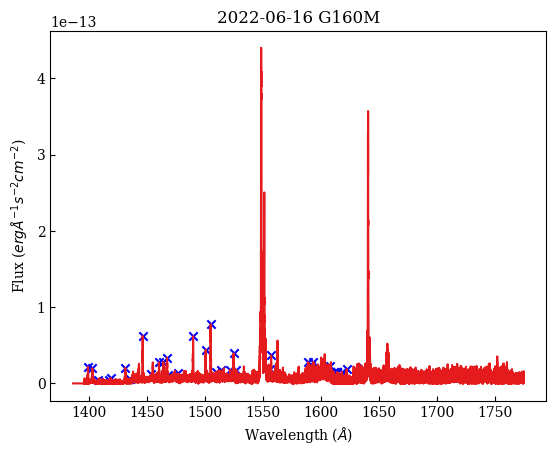

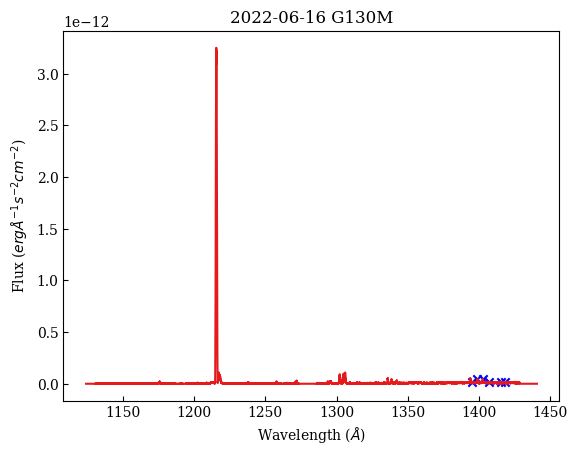

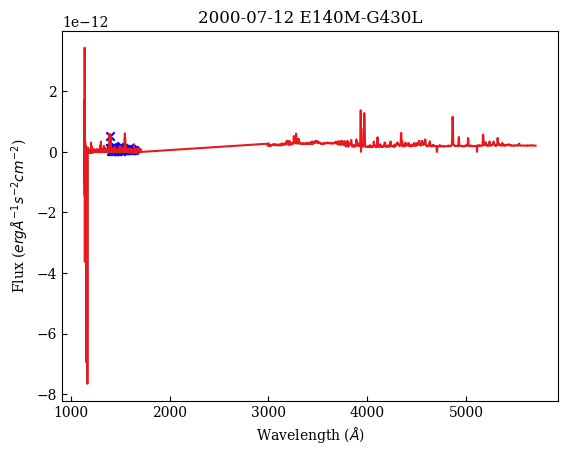

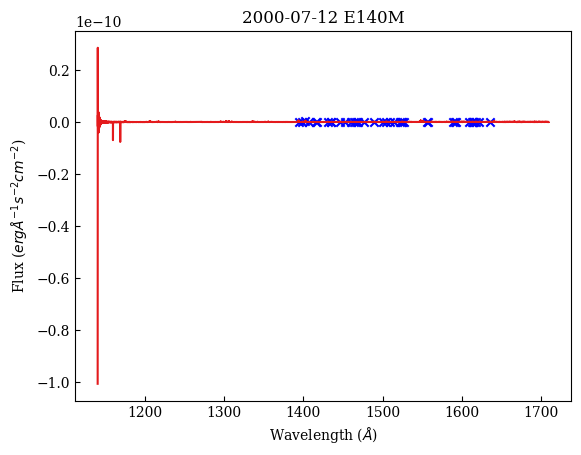

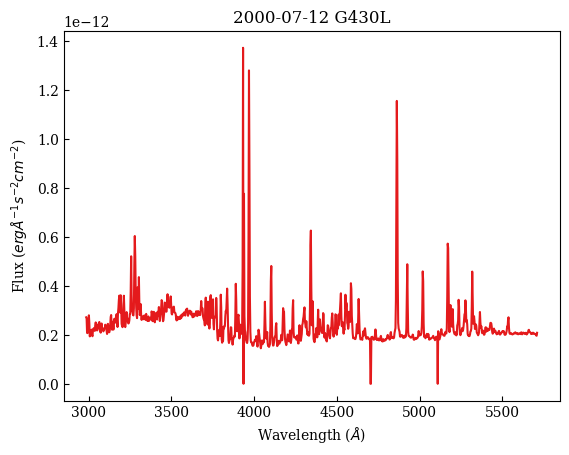

In [33]:
for _, row in stacked_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='b', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Now investigate individual lines

In [55]:
#stacked_df = stacked_df.loc[stacked_df['filter']!='G230L']
stacked_df = stacked_df[stacked_df["[nu', J']"].notna()]
stacked_df

,obsdate,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']",rest_wavelength
0,2011-07-20,G130M,"[1124.7185766387568 Angstrom, 1124.72853832954...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[31744, 28522, 28891, 28159, 29353]","[[1,4], [0,1], [0,2], [0,3], [0,3]]","[1431.01, 1398.95, 1402.65, 1395.2, 1407.29]"
1,2011-07-20,G160M,"[1386.0412954067515 Angstrom, 1386.05353027634...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[10072, 17936, 11521, 6621, 9356, 11336, 13958...","[[4,13], [3,16], [4,4], [1,7], [1,7], [1,7], [...","[1509.45, 1593.26, 1526.55, 1467.08, 1500.45, ..."
2,2012-02-28,G130M,"[1124.9096635174221 Angstrom, 1124.91962690073...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30139, 30456, 31739, 32095, 28467, 28891, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [...","[1415.33, 1418.23, 1431.01, 1435.05, 1398.95, ..."
3,2012-02-28,G160M,"[1386.2769487823698 Angstrom, 1386.28918573199...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19178, 19697, 2391, 10081, 19629, 2578, 10459...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
4,2021-08-10,G230L,"[1629.7767989689344 Angstrom, 1630.16885217535...",[-8.040355697789332e-16 erg / (Angstrom s cm2)...,"[3.668935098550417e-14 erg / (Angstrom s cm2),...",[],[],[]
5,2021-08-10,G160M,"[1385.9946471407397 Angstrom, 1386.00688689571...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19597, 2424, 10078, 19597, 2620, 10481, 17913...","[[3,13], [4,13], [4,13], [4,13], [3,16], [3,16...","[1615.43, 1415.33, 1509.45, 1613.99, 1418.23, ..."
6,2021-08-11,G160M,"[1385.9941396590698 Angstrom, 1386.00637941009...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[],[]
7,2021-08-12,G230L,"[1302.44952981175 Angstrom, 1302.864435088827 ...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[],[]
8,2021-08-12,G160M,"[1385.9934968299058 Angstrom, 1386.00573657483...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19021, 19603, 2360, 10072, 19603, 2626, 10489...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16...","[1608.33, 1615.43, 1415.33, 1509.45, 1613.99, ..."
9,2021-08-13,G230L,"[1630.0907947696835 Angstrom, 1630.48284648384...","[1.834981277742598e-14 erg / (Angstrom s cm2),...","[4.008633769678648e-14 erg / (Angstrom s cm2),...",[],[],[]


In [56]:
#! Breaks if there is only one line in the spectrum
line_width = 150
transitions = set(linelist['[nu\', J\']'])
line_dict = {'transition': [],
             'labline': [],
             'obsdate': [],
             'wavelength': [],
             'flux': [],
             'fluxerr': []}
for target_nuJ in transitions:
    for _, row in stacked_df.iterrows():
        if target_nuJ in row["[nu', J']"]:
            targ_idx = np.where(np.array(row["[nu', J']"])==target_nuJ)[0]
            line_idx = np.array(row.loc['H2line_idx'])[targ_idx]

            for i, l in enumerate(line_idx):
                line_dict['wavelength'].append(row['wavelength'][l-line_width:l+line_width])
                line_dict['flux'].append(row['flux'][l-line_width:l+line_width])
                line_dict['fluxerr'].append(row['fluxerr'][l-line_width:l+line_width])
                line_dict['obsdate'].append(row['obsdate'])
                line_dict['transition'].append(target_nuJ)
                line_dict['labline'].append(np.array(row['rest_wavelength'])[targ_idx[i]])
        else:
            pass

line_df = pd.DataFrame(line_dict)

In [57]:
line_df

,transition,labline,obsdate,wavelength,flux,fluxerr
0,"[2,15]",1612.39,2012-02-28,"[1610.807831093265 Angstrom, 1610.820072418921...","[4.156931255648865e-14 erg / (Angstrom s cm2),...","[9.443073056888842e-15 erg / (Angstrom s cm2),..."
1,"[2,15]",1617.42,2012-02-28,"[1615.3616042375165 Angstrom, 1615.37384556317...","[5.419979786656396e-14 erg / (Angstrom s cm2),...",[1.0110212124766293e-14 erg / (Angstrom s cm2)...
2,"[2,15]",1612.39,2021-08-10,"[1611.6918996621785 Angstrom, 1611.70414724122...",[-5.612276857617954e-17 erg / (Angstrom s cm2)...,[1.2131195706180722e-14 erg / (Angstrom s cm2)...
3,"[2,15]",1612.39,2021-08-12,"[1611.764093200788 Angstrom, 1611.776340769783...",[-9.066961613487701e-17 erg / (Angstrom s cm2)...,[1.2133239596682447e-14 erg / (Angstrom s cm2)...
4,"[2,15]",1612.39,2021-08-13,"[1611.7514027863897 Angstrom, 1611.76365035218...",[-6.799026265002882e-17 erg / (Angstrom s cm2)...,[1.2128665618767274e-14 erg / (Angstrom s cm2)...
...,...,...,...,...,...,...
905,"[4,4]",1526.55,2000-07-12,"[1523.7177734375 Angstrom, 1523.7362060546875 ...","[2.95152628466272e-14 erg / (Angstrom s cm2), ...","[6.028588082147168e-15 erg / (Angstrom s cm2),..."
906,"[4,4]",1613.72,2000-07-12,"[1610.87109375 Angstrom, 1610.8895263671875 An...",[3.7152992813337116e-14 erg / (Angstrom s cm2)...,"[9.222143589270117e-15 erg / (Angstrom s cm2),..."
907,"[4,4]",1477.05,2000-07-12,"[1474.2288818359375 Angstrom, 1474.24731445312...",[1.2893777774527874e-14 erg / (Angstrom s cm2)...,"[5.573335897394388e-15 erg / (Angstrom s cm2),..."
908,"[4,4]",1526.55,2000-07-12,"[1523.7177734375 Angstrom, 1523.7362060546875 ...","[2.95152628466272e-14 erg / (Angstrom s cm2), ...","[6.028588082147168e-15 erg / (Angstrom s cm2),..."


In [38]:
len(line_df[line_df.duplicated(subset=['transition', 'labline', 'obsdate'], keep="first")])

55

In [58]:
result_df = all_spectra.coaddwave(line_df, columns=['obsdate', 'transition'])

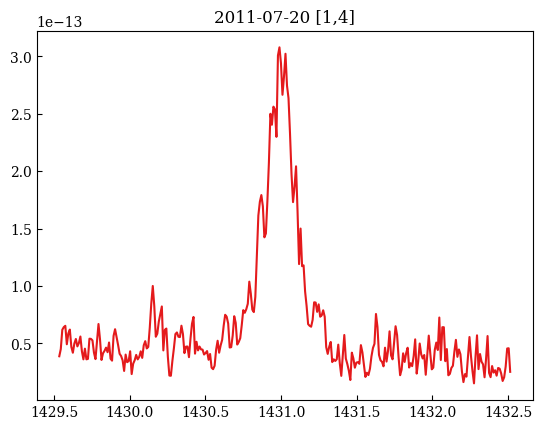

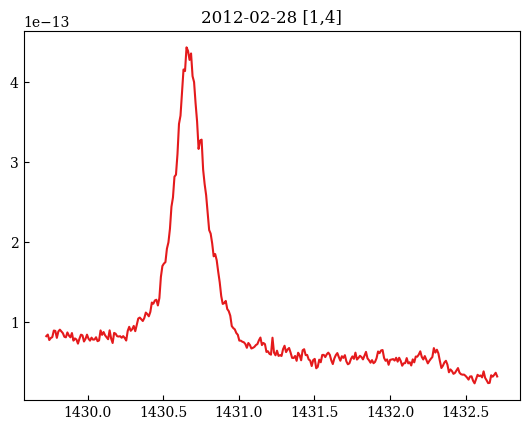

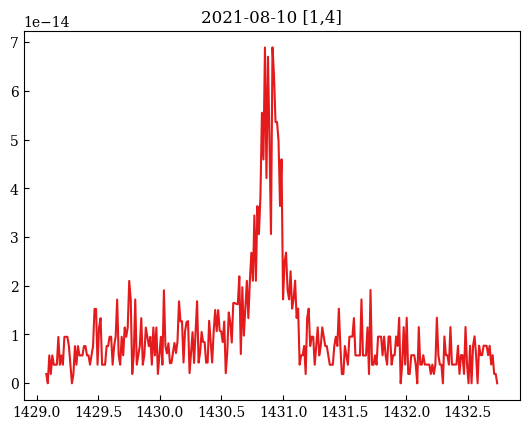

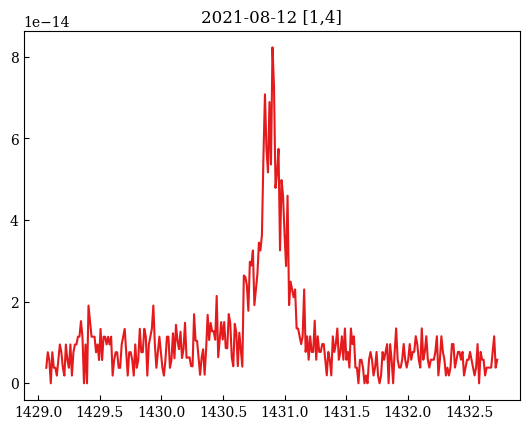

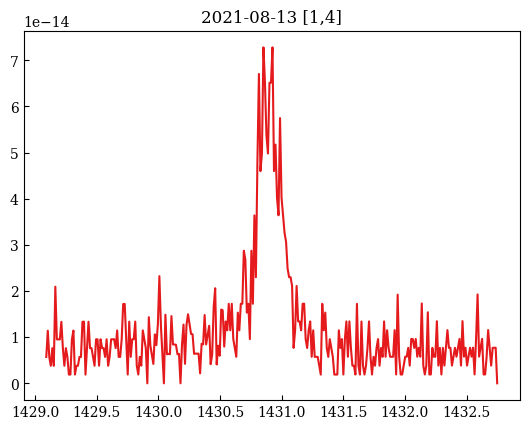

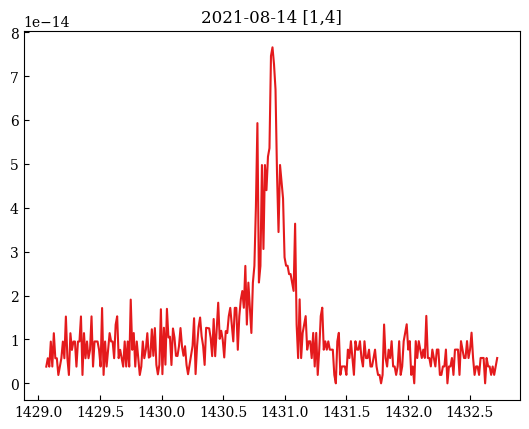

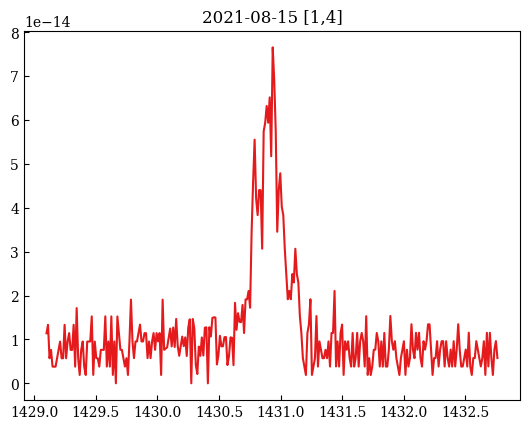

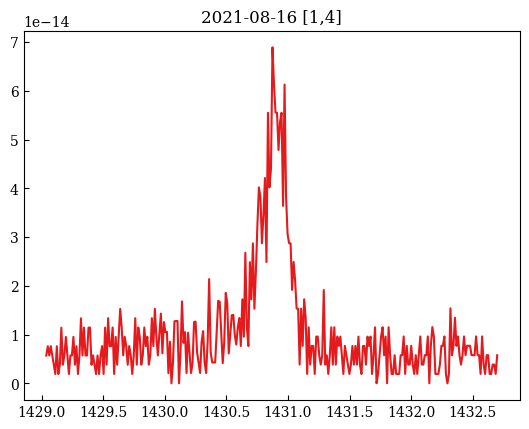

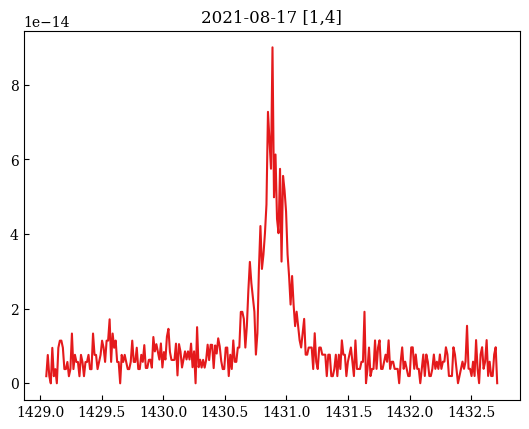

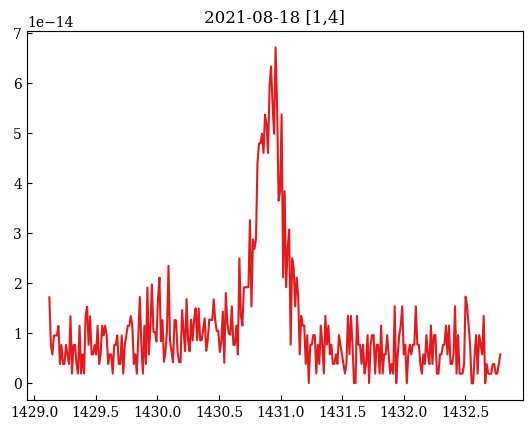

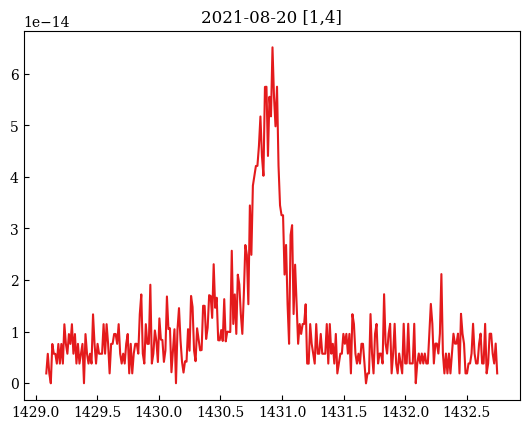

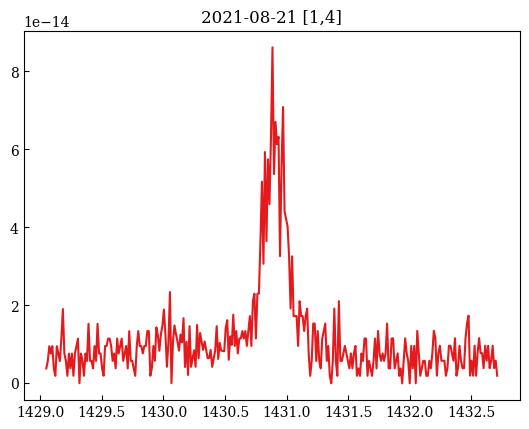

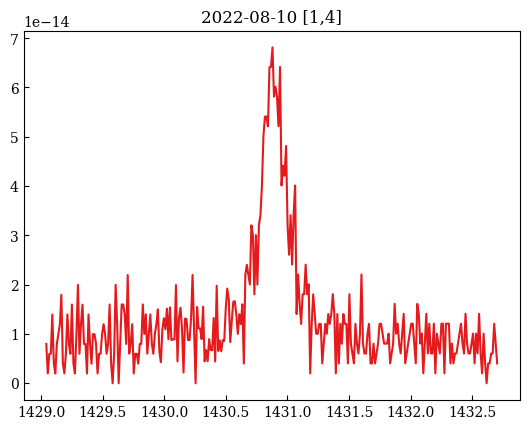

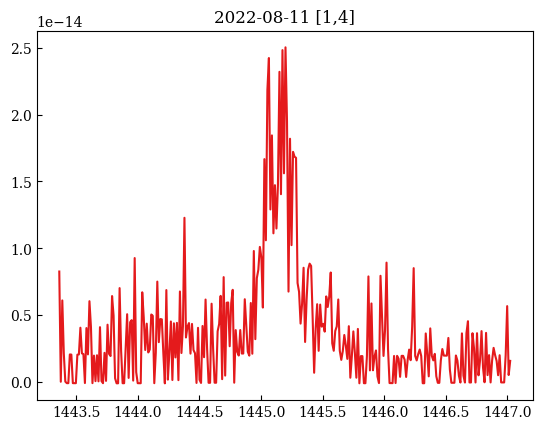

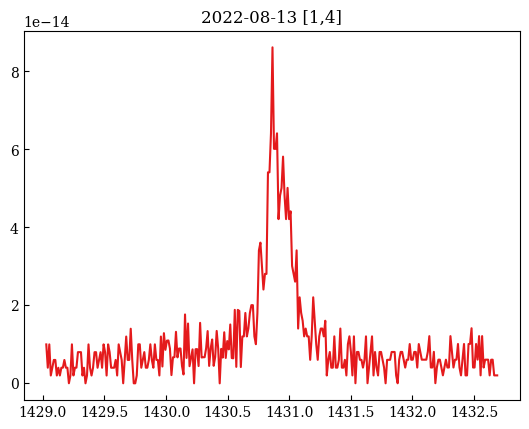

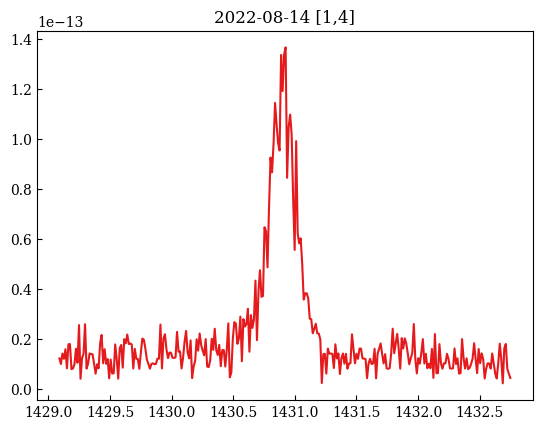

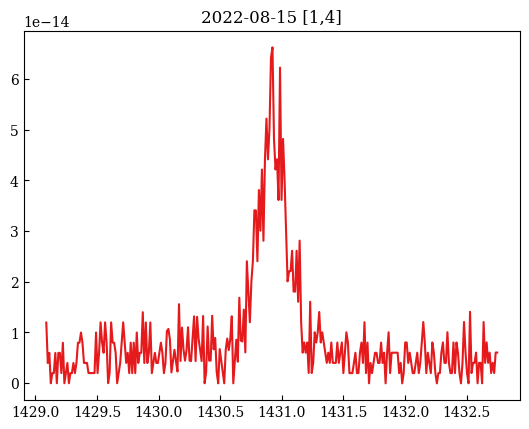

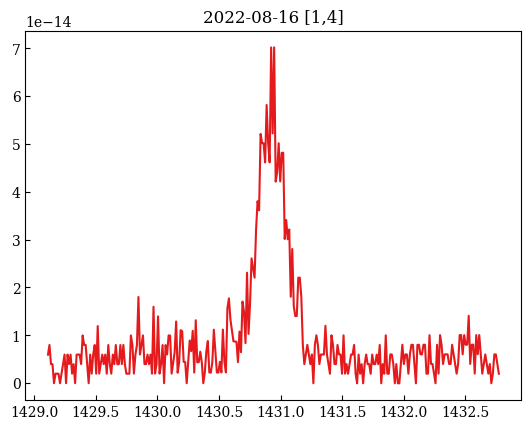

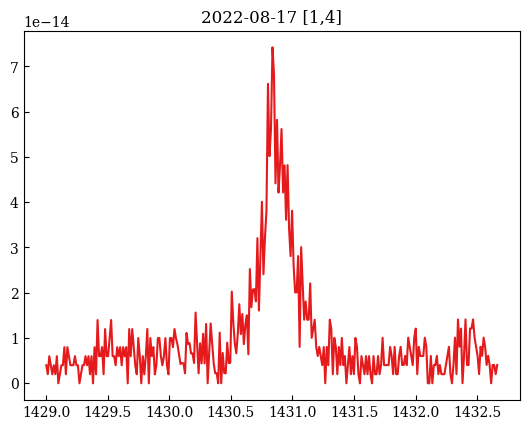

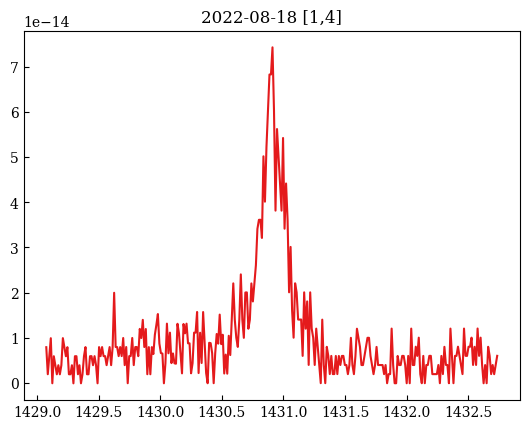

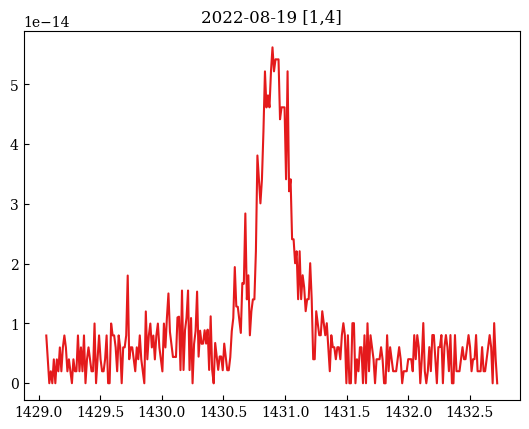

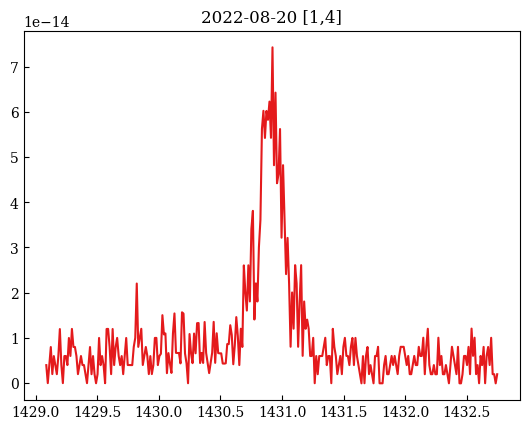

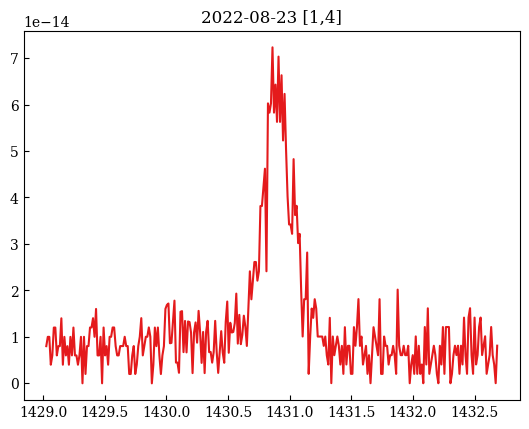

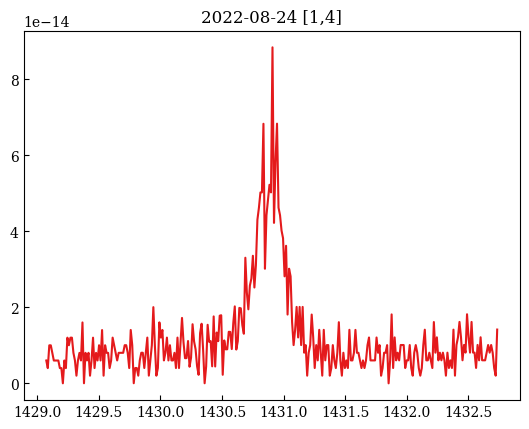

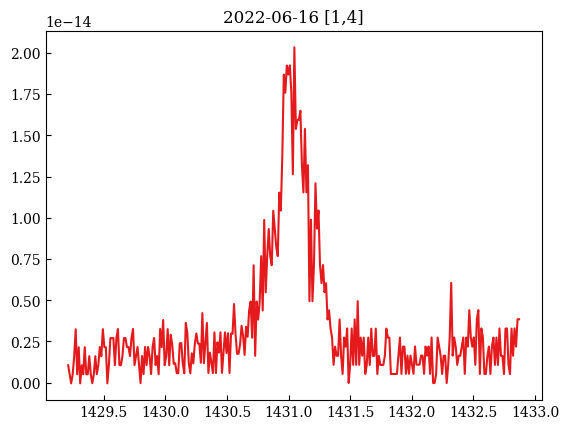

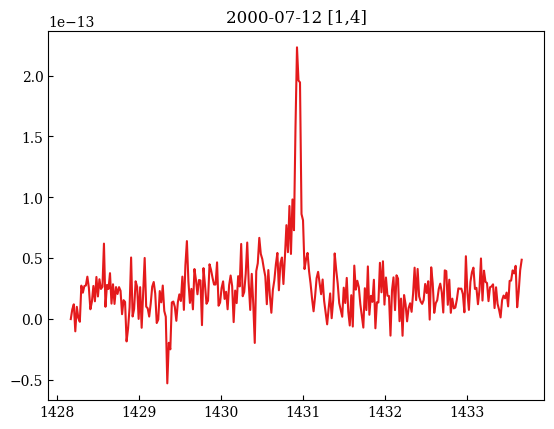

In [59]:
mask = result_df['transition']=='[1,4]'

for _, row in result_df[mask].iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.title(row['obsdate']+' '+row['transition'])
    plt.show()